<div>
<div style="text-align:center; display:block; float:left; padding:80px;"><img width="200px"  src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4651/logos/front_page.png"/><span style="color:red;">**New User Booking**</span></div>
<div style="">
**Objective:** In this recruiting competition, Airbnb challenges you to predict in which country a new user will make his or her first booking.  
  
** Description: ** In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.
</div>
<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4651/media/airbnb_banner.png" />

Author: [Oliveira, D. M.](http://br.linkedin.com/in/dmoliveira)

## <span style="color:blue">Airbnb - New User Booking - v6 Scikit-Learn All Models
Research source: http://scikit-learn.org/stable/

## Import Packages

In [1]:
using DataFrames
using MLBase
using Gadfly
using PyCall

  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:104
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:105
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163


In [2]:
@pyimport sklearn.linear_model as lm
@pyimport sklearn.svm as svm
@pyimport sklearn.neighbors as knn
@pyimport sklearn.naive_bayes as naive_bayes
@pyimport sklearn.tree as tree
@pyimport sklearn.ensemble as ensemble

## Load Data

In [3]:
train = readtable("data/train_v2.tsv", separator='\t')
test  = readtable("data/test_v2.tsv", separator='\t')
full = vcat(train, test);

In [4]:
label    = :country_destination
features = setdiff(names(test), [:id]);

## Prepare Data

In [5]:
function split_train_val(df; train_size=.85, random_state=1)
    
    srand(random_state)
    
    nrows, ntraining_rows = size(df, 1), round(Int, size(df, 1) * train_size)
    indexes               = shuffle(collect(1:nrows))
    train                 = df[indexes[1:ntraining_rows], :]
    validation            = df[indexes[ntraining_rows+1:end], :]
    
    return train, validation
end

split_train_val (generic function with 1 method)

In [6]:
train[label]  -= 1
X_train, X_val = split_train_val(train, train_size=.85, random_state=1)

train_x = Array{Float64,2}(X_train[:, features])
train_y = Array{Float64,1}(X_train[label])
val_x   = Array{Float64,2}(X_val[:, features])
val_y   = Array{Float64,1}(X_val[label])
test_x  = Array{Float64,2}(test[:, features]);

In [7]:
nrows, ncols = size(train_x);

## Prepare Training Models

In [8]:
fit(model, X, y) = model[:fit](X[1:end,:], y[1:end])

fit (generic function with 1 method)

In [9]:
function create_bagging_model(base_model)
    return ensemble.BaggingClassifier(
        base_model, max_samples=0.5, max_features=0.5, 
        random_state=0, n_jobs=-1)
end

function create_ada_boost_model(base_model)
    return ensemble.AdaBoostClassifier(
        base_model, n_estimators=10, random_state=0,
    algorithm="SAMME")
end

create_ada_boost_model (generic function with 1 method)

In [10]:
regressor_models = Dict(
    :OLS                => lm.LinearRegression(),
    :Ridge              => lm.Ridge(alpha=.5), 
    :Lasso              => lm.Lasso(alpha=.5), 
    :ElasticNet         => lm.ElasticNet(alpha=.5, l1_ratio=0.5), 
    :LARS               => lm.Lars(), 
    :LassoLARS          => lm.LassoLars(alpha=1),
    :BayesianRidge      => lm.BayesianRidge(),
    :Perceptron         => lm.Perceptron(penalty="elasticnet", alpha=.5)
)
class_models = Dict(
    :LogisticRegression => lm.LogisticRegression(),
    :SGDClassifier      => lm.SGDClassifier(alpha=.5),
    :PassiveAggressiveClassifier => lm.PassiveAggressiveClassifier(),
    # :SVMClassifier      => svm.SVC(), # Too slow!! Crash!
    # :kNN                => knn.KNeighborsClassifier(n_neighbors=2, algorithm="ball_tree"),
    :NaiveBayes         => naive_bayes.GaussianNB(),
    :DecisionTree       => tree.DecisionTreeClassifier(),
    :ExtremyTree        => tree.ExtraTreeClassifier())

ensemble_models = Dict(
    :RandomForest => ensemble.RandomForestClassifier(n_estimators=10, max_depth=6, random_state=0),
    :ExtraTrees   => ensemble.ExtraTreesClassifier(n_estimators=10, max_depth=6, random_state=0),
    #:GradientBoostingTrees => ensemble.GradientBoostingClassifier(n_estimators=10, learning_rate=0.5, 
    #                                                               random_state=0)
)

bagging_models = Dict([symbol(:Bagging_, key) => create_bagging_model(class_models[key]) 
    for key in [:DecisionTree, :ExtremyTree]])

boosting_models = Dict([symbol(:Boosting_, key) => create_ada_boost_model(class_models[key])
    for key in [:DecisionTree, :ExtremyTree]])

all_models = merge(class_models, bagging_models, boosting_models, ensemble_models);

## Train

In [11]:
for (i, key) in enumerate(keys(all_models))
    println("Training Model $key ($i/$(length(all_models)))...")
    tic(); fit(all_models[key], train_x, train_y); toc()
end

Training Model ExtremyTree (1/12)...
elapsed time: 4.151836195 seconds
Training Model RandomForest (2/12)...
elapsed time: 6.80556211 seconds
Training Model PassiveAggressiveClassifier (3/12)...
elapsed time: 15.553391888 seconds
Training Model LogisticRegression (4/12)...
elapsed time: 121


signal (15): Terminated: 15
sem_post at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15

signal (15): Terminated: 15

signal (15): Terminated: 15
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)


.747985532 seconds
Training Model Bagging_ExtremyTree (5/12)...
elapsed time: 13.298953118 seconds
Training Model NaiveBayes (6/12)...
elapsed time: 3.213076499 seconds
Training Model DecisionTree (7/12)...
elapsed time: 16


signal (15): Terminated: 15
_kernelrpc_mach_vm_deallocate_trap at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15

signal (15): Terminated: 15
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)


.452395949 seconds
Training Model Bagging_DecisionTree (8/12)...
elapsed time: 37.356569972 seconds
Training Model Boosting_ExtremyTree (9/12)...
elapsed time: 21.386520399 seconds
Training Model Boosting_DecisionTree (10/12)...
elapsed time: 168.253323106 seconds
Training Model SGDClassifier (11/12)...
elapsed time: 9.63662046 seconds
Training Model ExtraTrees (12/12)...
elapsed time: 3

## Evaluate

In [12]:
eval_rmse(y, yhats) = round(sqrt(sum((y - yhats) .^ 2)/length(y)), 4)
eval_precision(y, yhats) = round(sum(Array{Int,1}(y .== yhats))/length(y), 4)

eval_precision (generic function with 1 method)

In [13]:
yhats_train = Dict([key => all_models[key][:predict](train_x[1:end, :]) for key in keys(all_models)])
yhats_val = Dict([key => all_models[key][:predict](val_x[1:end, :]) for key in keys(all_models)]);


signal (15): Terminated: 15

signal (15): Terminated: 15

signal (15): Terminated: 15

signal (15): Terminated: 15
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15
sem_post at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15

signal (15): Terminated: 15
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)
__munmap at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15

signal (15): Terminated: 15
madvise at /usr/lib/system/libsystem_kernel.dylib (unknown line)
madvise at /usr/lib/system/libsystem_kernel.dylib (unknown line)

signal (15): Terminated: 15
madvise at /usr/lib/sys

In [14]:
rmse_train = [eval_rmse(train_y[1:end], yhats_train[key]) for key in keys(yhats_train)]
precision_train = [eval_precision(train_y[1:end], yhats_train[key]) for key in keys(yhats_train)];

.773667097 seconds


In [15]:
rmse_val = [eval_rmse(val_y[1:end], yhats_val[key]) for key in keys(yhats_val)]
precision_val = [eval_precision(val_y[1:end], yhats_val[key]) for key in keys(yhats_val)];

In [16]:
model_names    = vcat(fill(collect(keys(all_models)), 4)...)
half_length    = round(Int, length(model_names)/2)
quarter_length = round(Int, half_length/2)
data_types     = repeach(["Train", "Validation"], half_length)
metrics        = repeach(["RMSE", "Precision", "RMSE", "Precision"], quarter_length)
values         = vcat(rmse_train, precision_train, rmse_val, precision_val)
results        = DataFrame(model=model_names, data_type=data_types, metric=metrics, value=values);

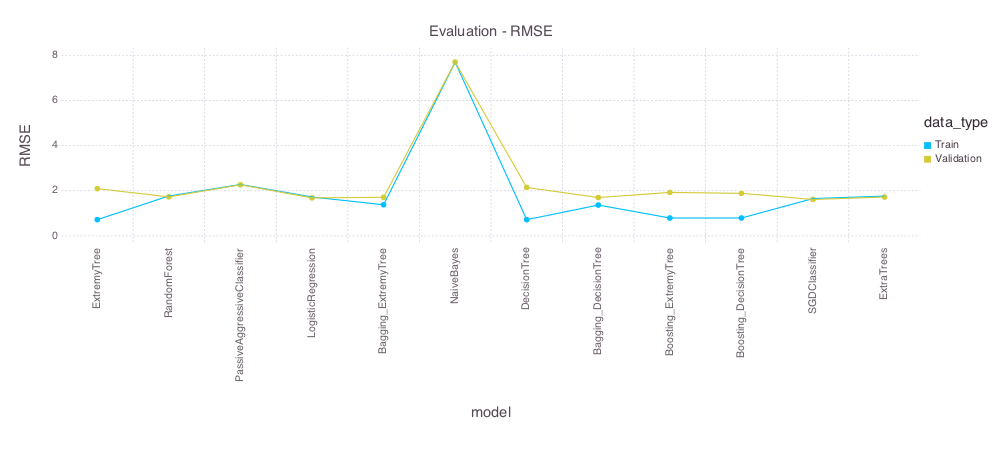

In [17]:
set_default_plot_size(1000px, 450px)
metric = "RMSE"
plot(results[results[:metric] .== metric, :], 
     x=:model, y=:value, color=:data_type, 
     Scale.x_discrete, Geom.line, Geom.point,
     Guide.title("Evaluation - $metric"),
     Guide.ylabel(metric))

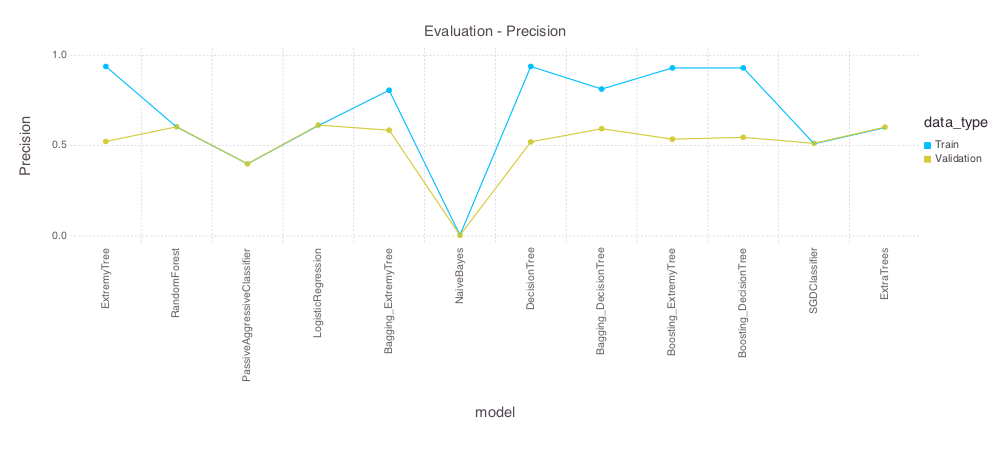

In [18]:
set_default_plot_size(1000px, 450px)
metric = "Precision"
plot(results[results[:metric] .== metric, :], 
     x=:model, y=:value, color=:data_type, 
     Scale.x_discrete, Geom.line, Geom.point,
     Guide.title("Evaluation - $metric"),
     Guide.ylabel(metric))

## Export Model